# Multiclass Task CNN Notebook

### Contains Code for Multiclass task CNN Model creation, training and testing<br/> CNN will be an implementation of AlexNet equivalent structure 5 convolutional layers and 3 fully connected layers

In [29]:
# Import required libraries
import numpy as np
from numpy import expand_dims
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#tqdm is for progress bar functionality in code, must be installed for code to function (TO DO: include exception if tqdm not imported )
from tqdm import tqdm

import pickle as pkl
import cv2

#Libraries for CNN model
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

#Importing functions notebook containing functions created to streamline code
from ipynb.fs.full.functions import load_dataset_CNN

# 1. Loading Labels and Resized Image Dataset
### 1.1 Loading Dataset via load_dataset_CNN function in "function.ipynb"

In [30]:
#Calls load_dataset_CNN function from function.ipynb to obtain the MRI images dataset and the Multiclass label pickle file and loads it respectively 
#into our X and Y value. Function also conducts rescaling of image pixel data from 0 to 255 to 0 to 1 range.
X, Y = load_dataset_CNN('./dataset/CNN_Images_2D_DF.pkl', './dataset/Y_Multiclass_Label.pkl')

Datasets successfully loaded with shapes:
X Shape:
(3000, 50, 50, 1)
Y Shape:
(3000,)


#### 1.1.1 Making Multiclass target labels into "one-hot" Array

### 1.2 Splitting dataset

In [31]:
# Split the data into training and testing(70% training and 30% testing data)
# Setting random_state to 42 keeps the same random generator seed to be used.
# This maintains the split used across code executions so results obtained will be the same for other users
xTrain,xTest,yTrain,yTest=train_test_split(X, Y, train_size = 0.7, random_state = 42)

#### 1.2.1 Displaying label distribution<br/> We show the the number of samples in each class label 

In [32]:
#Number of Samples per class in training data
print("Training dataset number of samples per class:")
print(yTrain.value_counts())

#Number of Samples per class in test data
print("Test dataset number of samples per class:")
print(yTest.value_counts())

#These values should match the number of samples in the multiclass SVM train test splits

Training dataset number of samples per class:
1.0    603
2.0    591
3.0    586
0.0    320
Name: MRI_Multiclass_Label, dtype: int64
Test dataset number of samples per class:
2.0    264
1.0    257
3.0    245
0.0    134
Name: MRI_Multiclass_Label, dtype: int64


In [33]:
#Before we proceed to model building we need to reconfigure the training set labels array into 
# categories or "one-hot" encoding for the multiclass CNN outputs
yTrain_OneHot = to_categorical(yTrain)

#Verifies new shape of target label array to be a 2100 by 4 matrix
print(yTrain_OneHot.shape)
print(yTrain_OneHot)

(2100, 4)
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


# 2. CNN Model Building

### 2.1 Defining model structure

In [34]:
#Initialising the Model
Multiclass_CNN = Sequential(name = 'Multiclass_CNN')

#We use the same number of filters in all convolutional layers of the AlexNet Model
#Number of filters in the fully connected layers will be reduced to 2500 2500 and 500
#This is to reduce size of CNN so it can be fit into Github without LFS
# Final output layer will have 4 nodes which corresponds to the 4 target labels in the MRI image dataset

#1st Convolutional Layer
#Input arguements
#Filters: Number of output filters in convolution
Multiclass_CNN.add(Conv2D(filters = 96, input_shape = (X.shape[1], X.shape[2], 1), kernel_size = (11, 11), strides = (4, 4), padding = 'same', name="conv0"))
Multiclass_CNN.add(BatchNormalization(name = 'bn0'))
Multiclass_CNN.add(Activation('relu'))
Multiclass_CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


#2nd Convolutional Layer
Multiclass_CNN.add(Conv2D(filters = 256, kernel_size = (5, 5), strides = (1, 1), padding = 'same', name="conv1"))
Multiclass_CNN.add(BatchNormalization(name = 'bn1'))
Multiclass_CNN.add(Activation('relu'))
Multiclass_CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


#3rd Convolutional Layer
Multiclass_CNN.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = (1, 1), padding = 'same', name="conv2"))
Multiclass_CNN.add(BatchNormalization(name = 'bn2'))
Multiclass_CNN.add(Activation('relu'))


#4th Convolutional Layer
Multiclass_CNN.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = (1, 1), padding = 'same', name="conv3"))
Multiclass_CNN.add(BatchNormalization(name = 'bn3'))
Multiclass_CNN.add(Activation('relu'))


#5th Convolutional Layer
Multiclass_CNN.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', name="conv4"))
Multiclass_CNN.add(BatchNormalization(name = 'bn4'))
Multiclass_CNN.add(Activation('relu'))
Multiclass_CNN.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


#Passing through the Fully connected layers
#We set the number of neurons per layer as 2500 for now
#Less than orignal 4096
Multiclass_CNN.add(Flatten())

#1st Fully Connected Layer
Multiclass_CNN.add(Dense(2500, name = 'fc0'))
Multiclass_CNN.add(BatchNormalization(name = 'bnfc0'))
Multiclass_CNN.add(Activation('relu'))
Multiclass_CNN.add(Dropout(0.4))

#2nd Fully Connected Layer
Multiclass_CNN.add(Dense(2500, name = 'fc1'))
Multiclass_CNN.add(BatchNormalization(name = 'bnfc1'))
Multiclass_CNN.add(Activation('relu'))
Multiclass_CNN.add(Dropout(0.4))

#3rd Fully Connected Layer
Multiclass_CNN.add(Dense(500, name = 'fc2'))
Multiclass_CNN.add(BatchNormalization(name = 'bnfc2'))
Multiclass_CNN.add(Activation('relu'))
Multiclass_CNN.add(Dropout(0.4))


#Output Layer
Multiclass_CNN.add(Dense(4, name = 'fcOut'))
Multiclass_CNN.add(BatchNormalization())
Multiclass_CNN.add(Activation('softmax'))



Multiclass_CNN.summary()

Model: "Multiclass_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 13, 13, 96)        11712     
_________________________________________________________________
bn0 (BatchNormalization)     (None, 13, 13, 96)        384       
_________________________________________________________________
activation_10 (Activation)   (None, 13, 13, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 96)          0         
_________________________________________________________________
conv1 (Conv2D)               (None, 7, 7, 256)         614656    
_________________________________________________________________
bn1 (BatchNormalization)     (None, 7, 7, 256)         1024      
_________________________________________________________________
activation_11 (Activation)   (None, 7, 7, 256)      

### 2.2 Compiling Multiclass CNN Model

In [35]:
#Compiling the model
#Loss function is categorical_crossentropy
#Optimizer is Adam 
#Metrics to be observed are
# Accuracy (both training and validation)
# Categorical Accuracy
# Categorical Crossentropy
# AUC metric
Multiclass_CNN.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy', metrics.CategoricalAccuracy(), metrics.CategoricalCrossentropy(), metrics.AUC()])

### 2.3 Model Training
#### 2.3.1 Defining model training callbacks and parameters

In [36]:
#Learning Rate callback
lrr= ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.01, patience = 3, min_lr = 1e-5) 


#Earlystopping callback
#This will end the training before the final defined epoch if the validation loss plateaus for more than 5 epochs
#Validation loss is the metric which the callback is monitoring
ES = EarlyStopping(monitor = 'val_loss', patience = 5)

#Defining model training parameters
batch_size = 32
epochs = 30
learn_rate = 0.001

#### 2.3.2 Training Model with validation set derived from training dataset

In [37]:
#Training the Model
#Explanation of the fit arguements
#Validation_split splits the training data and uses that split set aside for model validation
#in this case we set aside 30% of our training data to be used as validation data and the remaining 70% is used for training
#This leaves the original 30% test set as our sample test data. Which will be use on top of the out of sample test data which will be released at a later date
#Batch size and epochs are based on parameters set previously
#verbose gives us a progress bar per epoch
#callbacks includes the learning rate reduction on plateau funtion and stopping the training early if the validation loss plateaus for more than 5 epochs

Multiclass_CNN.fit(xTrain, yTrain_OneHot, batch_size= batch_size, epochs= epochs, validation_split= 0.3,  verbose = 1, callbacks = [lrr, ES])
#History.history attribute is a record of training loss values and metrics values at successive epochs
#as well as validation loss values and validation metrics values (if applicable).

Train on 1470 samples, validate on 630 samples
Epoch 1/30
1470/1470 [==============================] - 10s 7ms/step - loss: 1.0693 - accuracy: 0.5490 - categorical_accuracy: 0.5490 - categorical_crossentropy: 1.0693 - auc_4: 0.8047 - val_loss: 2.0904 - val_accuracy: 0.3000 - val_categorical_accuracy: 0.3000 - val_categorical_crossentropy: 2.0904 - val_auc_4: 0.5669
Epoch 2/30
1470/1470 [==============================] - 4s 2ms/step - loss: 0.9083 - accuracy: 0.6381 - categorical_accuracy: 0.6381 - categorical_crossentropy: 0.9083 - auc_4: 0.8633 - val_loss: 2.4712 - val_accuracy: 0.2968 - val_categorical_accuracy: 0.2968 - val_categorical_crossentropy: 2.4712 - val_auc_4: 0.5390
Epoch 3/30
1470/1470 [==============================] - 3s 2ms/step - loss: 0.7522 - accuracy: 0.7218 - categorical_accuracy: 0.7218 - categorical_crossentropy: 0.7522 - auc_4: 0.9158 - val_loss: 1.6886 - val_accuracy: 0.3635 - val_categorical_accuracy: 0.3635 - val_categorical_crossentropy: 1.6886 - val_auc_4:

### 2.4 Assessing Model Training Performance

In [38]:
#Testing addressing of trained model history metrics
#Allows us to access the model training history stats such as accuracy in trianing and validation
#Shows us the available metrics to check
#Can change metrics available by changing metrics to be observed when compiling the model
print(Multiclass_CNN.history.history.keys())

#Obtains training accuracy and loss of the most recent epoch to be finished
acc = Multiclass_CNN.history.history['accuracy'][-1]
loss = Multiclass_CNN.history.history['loss'][-1]

print("Training accuracy: ", acc)
print("Training loss: ", loss)


dict_keys(['val_loss', 'val_accuracy', 'val_categorical_accuracy', 'val_categorical_crossentropy', 'val_auc_4', 'loss', 'accuracy', 'categorical_accuracy', 'categorical_crossentropy', 'auc_4', 'lr'])
Training accuracy:  0.9802721
Training loss:  0.2754546740833594


#### 2.4.1 Visualising Model parameters during training

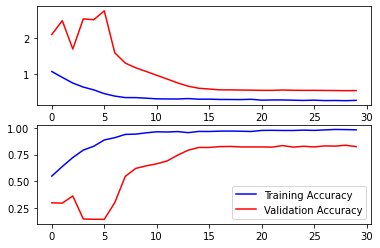

In [39]:
#Plotting the Training and validation loss

#Creating 2 subsplots under 1 figure
f, acc_plot = plt.subplots(2,1)

#First subplot graphs training loss and validation loss
acc_plot[0].plot(Multiclass_CNN.history.history['loss'], color = 'b', label = 'Training Loss')
acc_plot[0].plot(Multiclass_CNN.history.history['val_loss'], color = 'r', label = 'Validation Loss')
plt.legend()

#Second subplot graphs training accuracy and validation accuracy
acc_plot[1].plot(Multiclass_CNN.history.history['accuracy'], color = 'b', label = 'Training Accuracy')
acc_plot[1].plot(Multiclass_CNN.history.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

plt.legend()

# 3. Making Predictions with Trained Model

### 3.1 Obtaining Classification report and confusion matrix

In [40]:
#Making Predictions with the model
#We make 2 sets of predictions using the trained model. One which predicts the absolute class of the test image 
#and another subsequently which provides probability of the labels (0 or 1). The latter is used for ROC curve plotting
Multiclass_CNN_pred = Multiclass_CNN.predict_classes(xTest, verbose = 1)

#Printing the classification report and metrics
print("The Results for Multiclass CNN are:")
print(classification_report(yTest, Multiclass_CNN_pred))

#Printing the confusion matrix for Multiclass CNN
print("The confusion matrix is:")
print(confusion_matrix(yTest, Multiclass_CNN_pred))

#To obtain TNR, TPR and FPR metrics for Multiclass CNN in discrete form
FPR_Multiclass_CNN, TPR_Multiclass_CNN, Multiclass_CNN_thres = roc_curve(yTest, Multiclass_CNN_pred)
#TNR_Multiclass_CNN = 

900/900 [==============================] - 1s 936us/step
The Results for Multiclass CNN are:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83       134
         1.0       0.81      0.82      0.82       257
         2.0       0.78      0.75      0.76       264
         3.0       0.90      0.94      0.92       245

    accuracy                           0.83       900
   macro avg       0.83      0.83      0.83       900
weighted avg       0.83      0.83      0.83       900

The confusion matrix is:
[[111   6  10   7]
 [  5 211  36   5]
 [ 15  38 197  14]
 [  2   4   9 230]]


### 3.2 Obtaining ROC curve and other metrics of Multiclass CNN model

In [1]:
#Printing the main metrics to assess performance of the Multiclass CNN model
print("The metrics for Multiclass CNN model are as follows")
print("True Positive Rate: ", print(TPR_Multiclass_CNN))
print("True Negative Rate: ", print(TNR_Multiclass_CNN))
print('roc_auc_score for Multiclass CNN: ', roc_auc_score(yTest, Multiclass_CNN_pred))

NameError: name 'roc_auc_score' is not defined

# 4. Saving Model

In [41]:
#Serialize Multiclass CNN model to json
#This saves the model architecture to save space
Multiclass_CNN_json = Multiclass_CNN.to_json()
with open(".\Models\MultiClassification\CNN\Multiclass_CNN.json", "w") as json_file:
    json_file.write(Multiclass_CNN_json)

#Saving the Multiclass_CNN Model weights 
Multiclass_CNN.save_weights(".\Models\MultiClassification\CNN\Multiclass_CNN_Model_Weights")
print("Saved model to disk")

Saved model to disk


In [42]:
#Test to load CNN Model
# load Multiclass CNN json and create model
json_file = open(".\Models\MultiClassification\CNN\Multiclass_CNN.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(".\Models\MultiClassification\CNN\Multiclass_CNN_Model_Weights")
print("Loaded model from disk")

Loaded model from disk
